In [2]:
import os
import sys
import pdb
import re
import json
import copy
import pickle
import glob
import h5py
import tqdm
import importlib
import functools
import multiprocessing
import numpy as np
import pandas as pd
import scipy.stats

%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import util_pitchnet_psychophysics_figures
importlib.reload(util_pitchnet_psychophysics_figures)
import util_localization_psychophysics
importlib.reload(util_localization_psychophysics)
import util_localization_psychophysics_figures
importlib.reload(util_localization_psychophysics_figures)
import util_spkr_word_psychophysics
importlib.reload(util_spkr_word_psychophysics)
import util_spkr_word_psychophysics_figures
importlib.reload(util_spkr_word_psychophysics_figures)

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_stimuli
import util_misc

tqdm.tqdm.pandas()


def get_color_and_label_from_model_tag(model_tag):
    if 'human' in model_tag.lower():
        color = 'k'
        label = 'Human listeners'
    elif 'before_pool_factor1' in model_tag.lower():
        color = 'b'
        label = 'before_pool_x1'
    elif 'before_pool_factor2ish' in model_tag.lower():
        color = 'g'
        label = 'before_pool_x2ish'
    elif 'before_pool_factor2' in model_tag.lower():
        color = 'orange'
        label = 'before_pool_x2'
    elif 'ihc3000' in model_tag.lower():
        color = '#808088'#np.array([0, 0, 0])/256
        label = '3000 Hz IHC filter'
    elif 'ihc1000' in model_tag.lower():
        color = '#28C8C8'#np.array([66, 109, 171])/256
        label = '1000 Hz IHC filter'
    elif 'ihc0320' in model_tag.lower():
        color = '#8856a7'
        label = '320 Hz IHC filter'
    elif 'ihc0050' in model_tag.lower():
        color = '#F03C8C'#np.array([221, 51, 126])/256
        label = '50 Hz IHC filter'
    elif 'cochlearn' in model_tag.lower():
        color = 'g'
        label = 'Learned coch filts'
    else:
        color = None
        label = os.path.basename(model_tag)
    return color, label


def make_plot_aggregate_measures(
        df,
        list_tag_expt=[],
        list_tag_model=[],
        width=0.15,
        ci_percentile=95,
        key_metric='pearsonr',
        ylimits=[0, 1.15],
        yticks=np.arange(0, 1.01, 0.2),
        str_ylabel="Human-model similarity\n(Pearson's $r$ with 95% CI)"):
    """
    """
    fig, ax = plt.subplots(figsize=(12, 3))
    xticks = []
    xticklabels = []
    for itr_expt, tag_expt in enumerate(list_tag_expt):
        xticks.append(itr_expt)
        xticklabels.append(tag_expt)
        for itr_model, tag_model in enumerate(list_tag_model):
            color, label = get_color_and_label_from_model_tag(tag_model)
            dfi = df[np.logical_and.reduce([
                df['tag_expt'] == tag_expt,
                df['tag_model'] == tag_model,
            ])]
            if len(dfi) == 1:
                dfi = dfi.iloc[0]
                x = itr_expt + (itr_model - 1.5) * width
                y = dfi[key_metric]
                yerr = 2 * np.std(dfi[f'bootstrap_list_{key_metric}'])
                ci = np.percentile(
                    dfi[f'bootstrap_list_{key_metric}'],
                    [(100 - ci_percentile) / 2, ci_percentile + (100 - ci_percentile) / 2])
                yerr = np.array([y - ci[0], ci[1] - y]).reshape([2, 1])
                ax.bar(
                    x,
                    y,
                    yerr=yerr,
                    width=width,
                    facecolor=color,
                    edgecolor='k',
                    capsize=4,
                    label=label if itr_expt == 0 else None)
    ax.legend(
        loc='upper center',
        frameon=False,
        fontsize=9,
        ncol=len(list_tag_model),
        columnspacing=1,
        handletextpad=0.5,
    )
    ax.set_xticklabels(xticklabels, rotation=90)
    ax = util_figures.format_axes(
        ax,
        xticks=xticks,
        xticklabels=xticklabels,
        ylimits=ylimits,
        yticks=yticks,
        str_ylabel=str_ylabel)
    return fig, ax


In [10]:
importlib.reload(util_spkr_word_psychophysics)

list_regex_dir_model = [
    'saved_models/augmented_2022JAN/taskSW/IHC3000Hz_anf384H160M096L/arch0_00??',
    'saved_models/augmented_2022JAN/taskSW/IHC1000Hz_anf384H160M096L/arch0_00??',
    'saved_models/augmented_2022JAN/taskSW/IHC0320Hz_anf384H160M096L/arch0_00??',
    'saved_models/augmented_2022JAN/taskSW/IHC0050Hz_anf384H160M096L/arch0_00??',
    'saved_models/augmented_2022JAN/taskSW/spont0_simplified_IHC3000/arch0_00??',
    'saved_models/augmented_2022JAN/taskSW/spont0_simplified_IHC1000/arch0_00??',
    'saved_models/augmented_2022JAN/taskSW/spont0_simplified_IHC0320/arch0_00??',
    'saved_models/augmented_2022JAN/taskSW/spont0_simplified_IHC0050/arch0_00??',
    'saved_models/augmented_2022JAN/task_S/IHC3000Hz_anf384H160M096L/arch0_00??',
    'saved_models/augmented_2022JAN/task_S/IHC1000Hz_anf384H160M096L/arch0_00??',
    'saved_models/augmented_2022JAN/task_S/IHC0320Hz_anf384H160M096L/arch0_00??',
    'saved_models/augmented_2022JAN/task_S/IHC0050Hz_anf384H160M096L/arch0_00??',
    'saved_models/augmented_2022JAN/task_W/IHC3000Hz_anf384H160M096L/arch0_00??',
    'saved_models/augmented_2022JAN/task_W/IHC1000Hz_anf384H160M096L/arch0_00??',
    'saved_models/augmented_2022JAN/task_W/IHC0320Hz_anf384H160M096L/arch0_00??',
    'saved_models/augmented_2022JAN/task_W/IHC0050Hz_anf384H160M096L/arch0_00??',
]

dict_basename_eval = {
    'kell_like_inharmonic': 'EVAL_word_recognition_human_experiment_v00_inharmonic_foreground60dbspl.json',
    'kell_like': 'EVAL_word_recognition_human_experiment_v00_foreground60dbspl.json',
    'speech_in_synthetic_textures': 'EVAL_word_recognition_speech_in_synthetic_textures.json',
    'pitch_altered': 'EVAL_pitch_altered_v00.json',
    'hopkins_moore_2009': 'EVAL_hopkins_moore_2009.json',
    'spkr_discrimination_timit_ssn': 'EVAL_spkr_discrimination_timit_ssn.json',
}

EXPERIMENT_DATAFRAMES = util_spkr_word_psychophysics.run_spkr_word_experiments(
    list_regex_dir_model,
    dict_basename_eval=dict_basename_eval)

for tag_experiment in EXPERIMENT_DATAFRAMES.keys():
    df = EXPERIMENT_DATAFRAMES[tag_experiment]
    print(f"--> {tag_experiment} ({len(df)}) <--")
#     for c in df.columns:
#         print(f"|__ {c}")


Loaded data for 10 `saved_models/augmented_2022JAN/taskSW/IHC3000Hz_anf384H160M096L/arch0_00??` models
Loaded data for 10 `saved_models/augmented_2022JAN/taskSW/IHC1000Hz_anf384H160M096L/arch0_00??` models
Loaded data for 10 `saved_models/augmented_2022JAN/taskSW/IHC0320Hz_anf384H160M096L/arch0_00??` models
Loaded data for 10 `saved_models/augmented_2022JAN/taskSW/IHC0050Hz_anf384H160M096L/arch0_00??` models
Loaded data for 10 `saved_models/augmented_2022JAN/taskSW/spont0_simplified_IHC3000/arch0_00??` models
Loaded data for 10 `saved_models/augmented_2022JAN/taskSW/spont0_simplified_IHC1000/arch0_00??` models
Loaded data for 10 `saved_models/augmented_2022JAN/taskSW/spont0_simplified_IHC0320/arch0_00??` models
Loaded data for 10 `saved_models/augmented_2022JAN/taskSW/spont0_simplified_IHC0050/arch0_00??` models
Loaded data for 10 `saved_models/augmented_2022JAN/task_S/IHC3000Hz_anf384H160M096L/arch0_00??` models
Loaded data for 10 `saved_models/augmented_2022JAN/task_S/IHC1000Hz_anf38

In [12]:
fn_data = '/om2/user/msaddler/tfauditoryutil/paper_phaselocknet/data/model_data_spkr_word.pkl'
with open(fn_data, 'wb') as f:
    pickle.dump(EXPERIMENT_DATAFRAMES, f)

with open(fn_data, 'rb') as f:
    EXPERIMENT_DATAFRAMES = pickle.load(f)

print(fn_data)


/om2/user/msaddler/tfauditoryutil/paper_phaselocknet/data/model_data_spkr_word.pkl


In [13]:
importlib.reload(util_spkr_word_psychophysics)

def rmse(x, y):
    return np.linalg.norm(x - y) / np.sqrt(x.shape[0])

dict_metric_function = {
    'pearsonr': scipy.stats.pearsonr,
    # 'spearmanr': scipy.stats.spearmanr,
    'rmse': rmse,
}

experiment_to_compfunc_map = {
    'kell_like_word': functools.partial(
        util_spkr_word_psychophysics.compare_word_recognition_kell_like,
        restrict_conditions=[0, 1, 2, 3]),
    'kell_like_word_dip_listening': functools.partial(
        util_spkr_word_psychophysics.compare_word_recognition_kell_like,
        restrict_conditions=[3, 4]),
    'speech_in_synthetic_textures': functools.partial(
        util_spkr_word_psychophysics.compare_word_recognition_speech_in_synthetic_textures),
    'pitch_altered_spkr_word': functools.partial(
        util_spkr_word_psychophysics.compare_recognition_pitch_altered, key_task=['spkr', 'word']),
    'pitch_altered_word': functools.partial(
        util_spkr_word_psychophysics.compare_recognition_pitch_altered, key_task='word'),
    'pitch_altered_spkr': functools.partial(
        util_spkr_word_psychophysics.compare_recognition_pitch_altered, key_task='spkr'),
    'hopkins_moore_2009_word': functools.partial(
        util_spkr_word_psychophysics.compare_word_recognition_hopkins_moore_2009),
    'spkr_discrimination_timit_ssn': functools.partial(
        util_spkr_word_psychophysics.compare_spkr_discrimination_timit_ssn),
}


def func_to_parallelize(tag_expt):
    compfunc = experiment_to_compfunc_map[tag_expt]
    tag_expt_for_dataframe = tag_expt
    for suffix in ['_spkr', '_word', '_dip_listening']:
        tag_expt_for_dataframe = tag_expt_for_dataframe.replace(suffix, '')
    df = EXPERIMENT_DATAFRAMES[tag_expt_for_dataframe]
    df_results = None
    for metric_key, metric_function in dict_metric_function.items():
        df_results_tmp = compfunc(
            df,
            bootstrap_repeats=1000,
            metric_function=metric_function)
        df_results_tmp = df_results_tmp.rename(columns={
            'metric': metric_key,
            'bootstrap_list_metric': f'bootstrap_list_{metric_key}',
        })
        df_results_tmp['tag_expt'] = tag_expt
        if df_results is None:
            df_results = df_results_tmp
        else:
            df_results = df_results.merge(df_results_tmp, on=['tag_expt', 'tag_model'])
    return df_results


with multiprocessing.Pool(60) as pool:
    list_df_results = pool.map(func_to_parallelize, list(experiment_to_compfunc_map.keys()))
df_results = pd.concat(list_df_results)

fn_metrics = '/om2/user/msaddler/tfauditoryutil/paper_phaselocknet/data/human_model_comparison_metrics_spkr_word.pkl'
df_results.to_pickle(fn_metrics)
print(fn_metrics)

dict_agg = {}
for k in dict_metric_function.keys():
    dict_agg[k] = 'mean'
    dict_agg[f'bootstrap_list_{k}'] = list
df_results_mean = df_results.groupby(['tag_model']).agg(dict_agg).reset_index()
for k in df_results_mean.columns:
    if 'bootstrap_list_' in k:
        df_results_mean[k] = df_results_mean[k].map(lambda _: np.array(list(_)).mean(axis=0))
df_results_mean['tag_expt'] = 'AVERAGE'
df_results_mean


/om2/user/msaddler/.conda/envs/tf/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/om2/user/msaddler/.conda/envs/tf/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/om2/user/msaddler/.conda/envs/tf/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/om2/user/msaddler/.conda/envs/tf/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/om2/user/msaddler/.conda/envs/tf/lib/python3.11/sit

/om2/user/msaddler/tfauditoryutil/paper_phaselocknet/data/human_model_comparison_metrics_spkr_word.pkl


,tag_model,pearsonr,bootstrap_list_pearsonr,rmse,bootstrap_list_rmse,tag_expt
0,saved_models/augmented_2022JAN/taskSW/IHC0050H...,0.648840,"[0.6425987160864227, 0.6529769336058837, 0.628...",0.543116,"[0.5434593222061553, 0.5371967965701194, 0.550...",AVERAGE
1,saved_models/augmented_2022JAN/taskSW/IHC0320H...,0.847463,"[0.8474584259388738, 0.8467010473601101, 0.845...",0.326821,"[0.3338764247400263, 0.3072840429361108, 0.331...",AVERAGE
2,saved_models/augmented_2022JAN/taskSW/IHC1000H...,0.846957,"[0.8441772233268071, 0.8479028381061532, 0.839...",0.238782,"[0.24313528112251528, 0.23295665328909596, 0.2...",AVERAGE
3,saved_models/augmented_2022JAN/taskSW/IHC3000H...,0.852844,"[0.8524164765095742, 0.8534958628782418, 0.856...",0.214783,"[0.21124511158565434, 0.21386615851457658, 0.2...",AVERAGE
4,saved_models/augmented_2022JAN/taskSW/spont0_s...,0.734922,"[0.7686996379102866, 0.7405921239453733, 0.738...",0.522843,"[0.5009724236368037, 0.520341771585625, 0.5219...",AVERAGE
5,saved_models/augmented_2022JAN/taskSW/spont0_s...,0.843688,"[0.8440084400599641, 0.8388999072631786, 0.839...",0.272033,"[0.27053866446360647, 0.29043029081070526, 0.2...",AVERAGE
6,saved_models/augmented_2022JAN/taskSW/spont0_s...,0.849466,"[0.8507354060000297, 0.8443681775922103, 0.848...",0.223531,"[0.23926234948351138, 0.22908096300711545, 0.2...",AVERAGE
7,saved_models/augmented_2022JAN/taskSW/spont0_s...,0.843059,"[0.8385999209501844, 0.8420715879486821, 0.842...",0.217479,"[0.22998066177534435, 0.23734389123935723, 0.2...",AVERAGE
8,saved_models/augmented_2022JAN/task_S/IHC0050H...,0.317260,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.851977,"[0.8513862910948219, 0.852085532445754, 0.8523...",AVERAGE
9,saved_models/augmented_2022JAN/task_S/IHC0320H...,0.500274,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.814472,"[0.8138915810035804, 0.816065605466155, 0.8147...",AVERAGE


/tmp/ipykernel_33366/3425181903.py:125: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels, rotation=90)


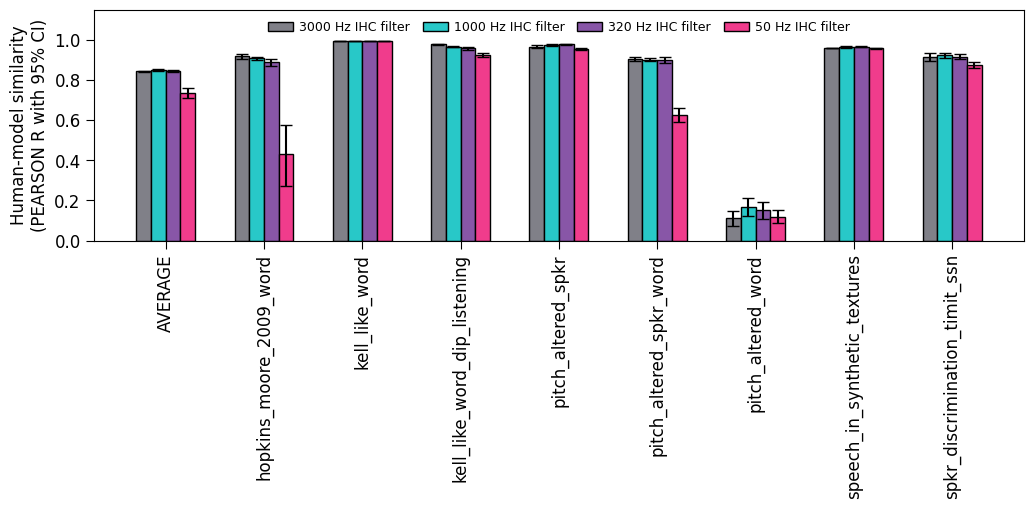

In [14]:
df = pd.concat([df_results, df_results_mean])
list_tag_expt = np.unique(df.tag_expt)
list_tag_model = np.unique(df.tag_model)[::-1]
list_tag_model = [_ for _ in list_tag_model if 'taskSW/spont0' in _]
fig, ax = make_plot_aggregate_measures(
    df,
    str_ylabel="Human-model similarity\n(PEARSON R with 95% CI)",
    list_tag_expt=list_tag_expt,
    list_tag_model=list_tag_model)


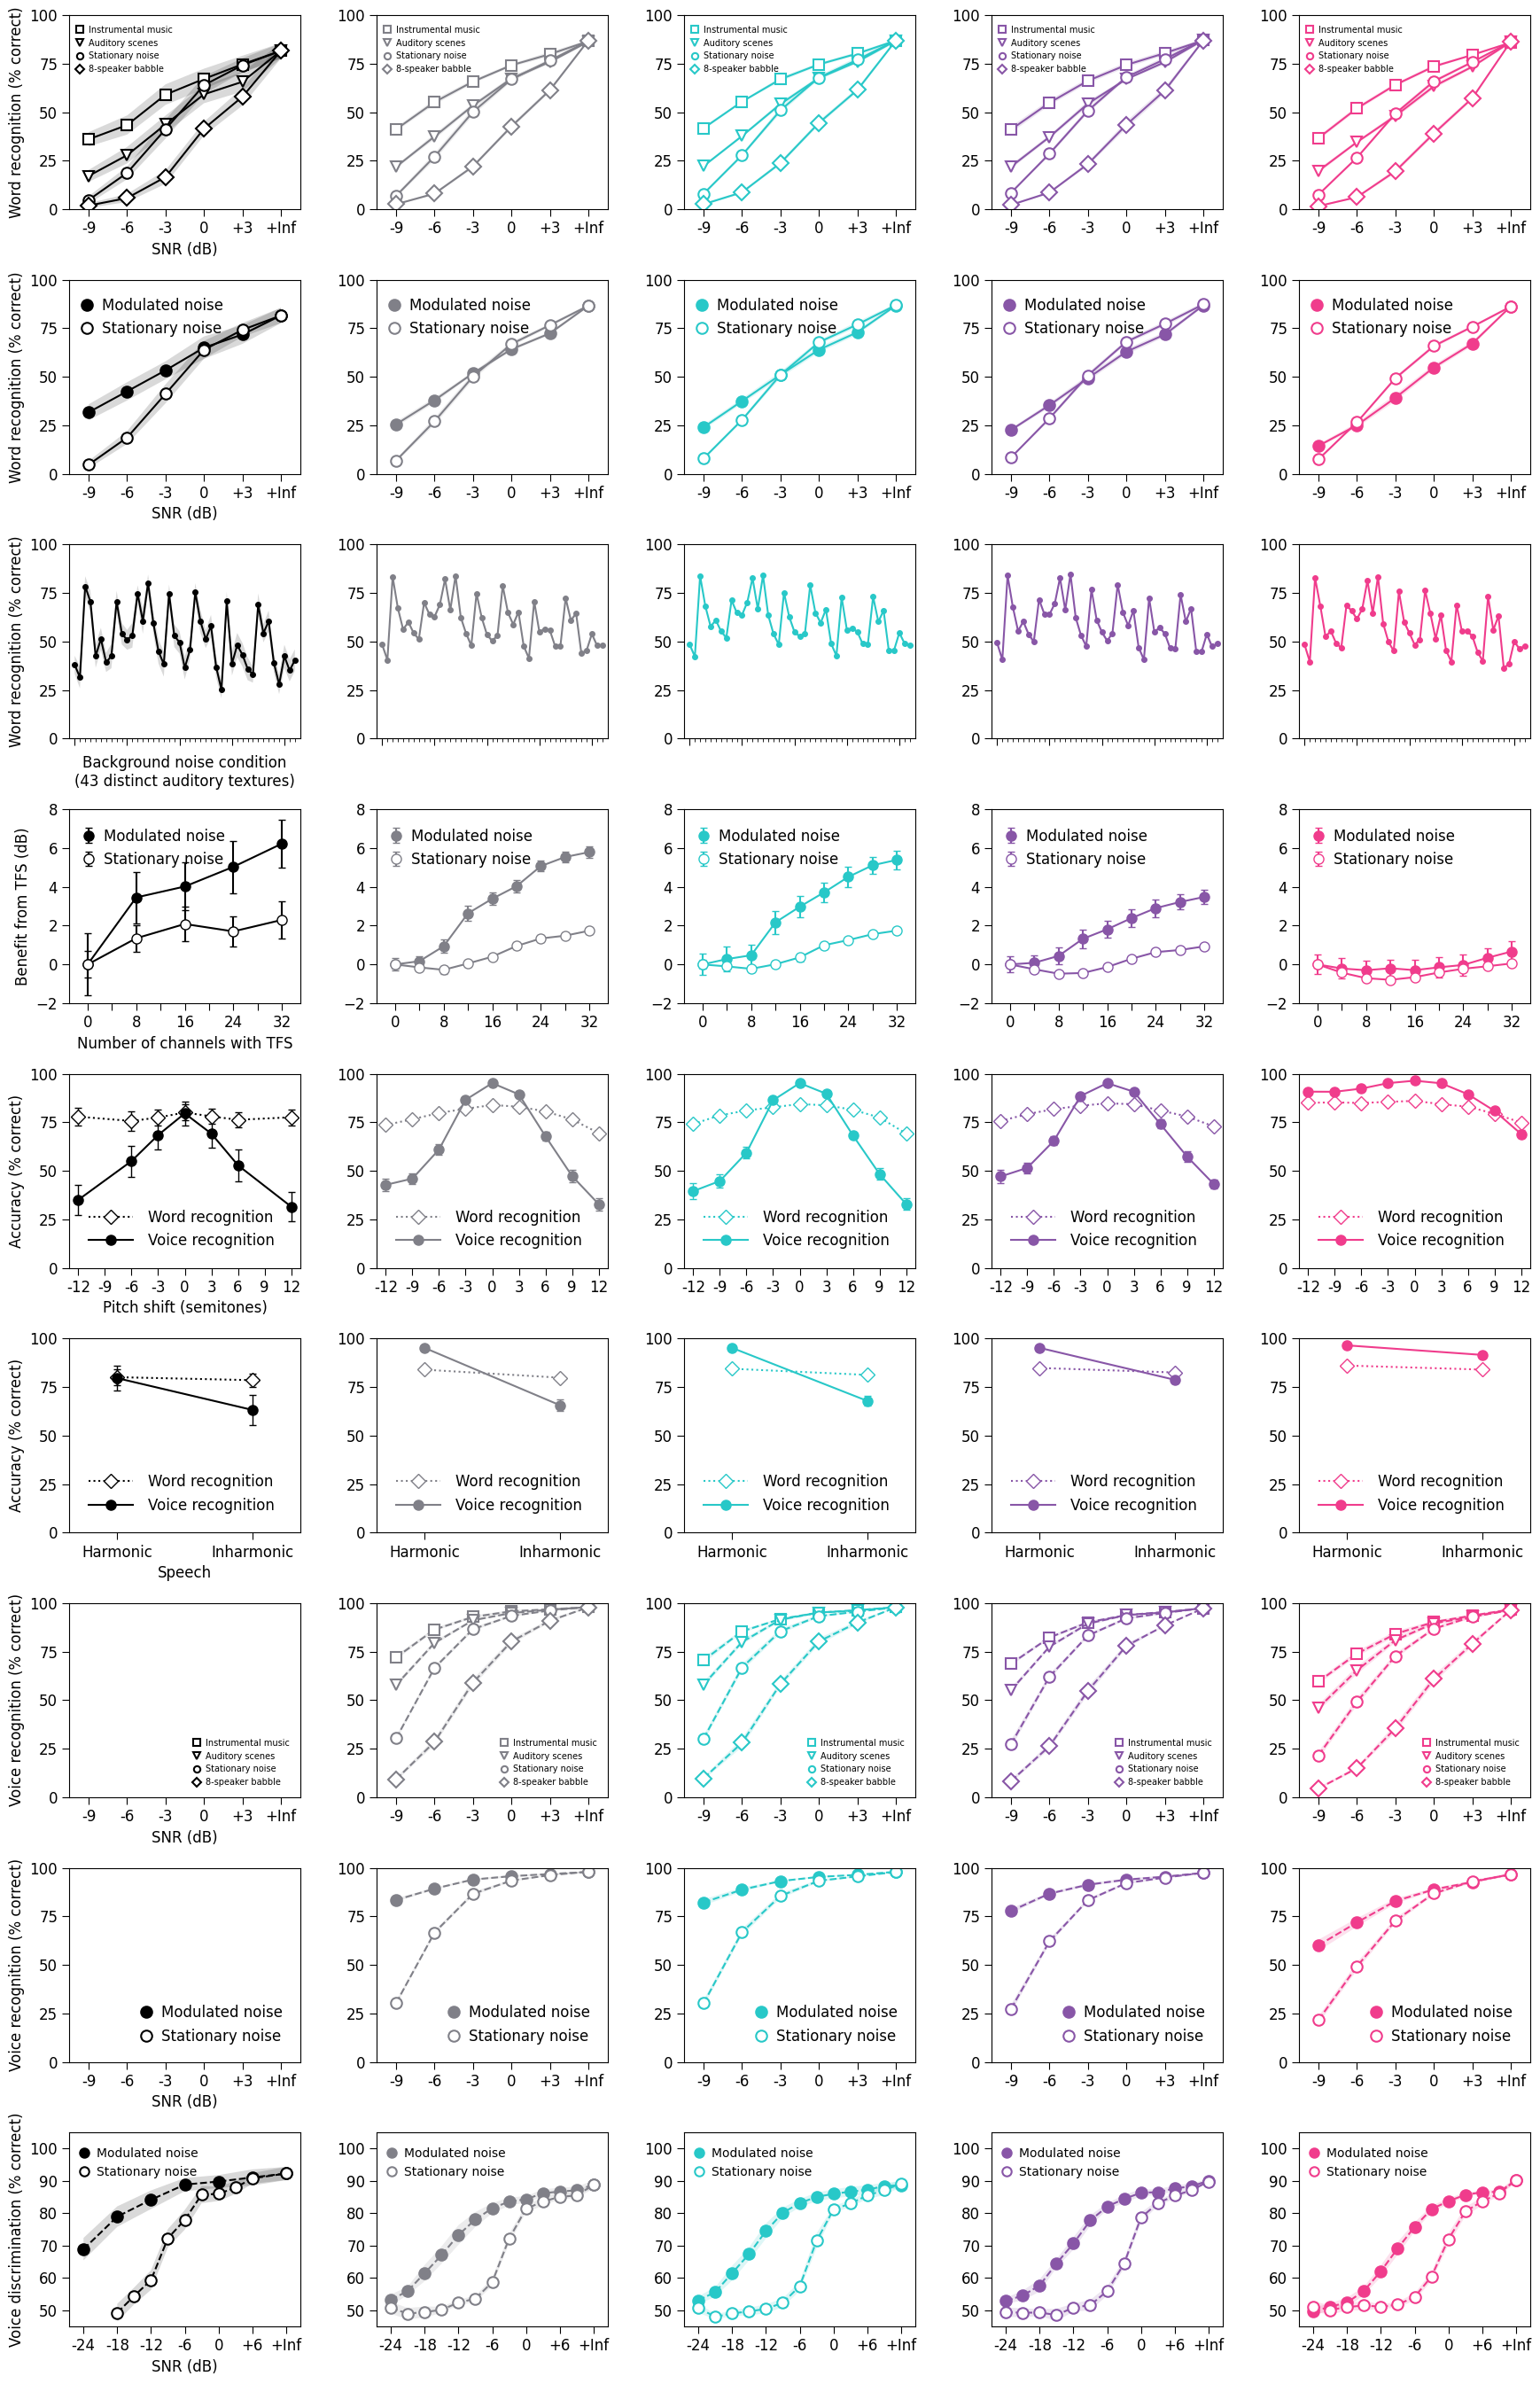

In [41]:
importlib.reload(util_spkr_word_psychophysics_figures)

list_tag_model = np.unique(df_results.tag_model.values)
list_tag_model = ['human'] + list_regex_dir_model[:4]
list_tag_expt = [
    'kell_like_word',
    'kell_like_word_dip_listening',
    'speech_in_synthetic_textures',
    'hopkins_moore_2009',
    'pitch_shifted',
    'pitch_condition',
    'kell_like_spkr',
    'kell_like_spkr_dip_listening',
    'spkr_discrimination_timit_ssn',
]

map_tag_expt_to_plot_func = {
    'kell_like_word': functools.partial(
        util_spkr_word_psychophysics_figures.make_plot_kell_like_recognition,
        key_task='word',
        fontsize_legend=7,
        restrict_background_condition=[2, 0, 3, 1]),
    'kell_like_word_dip_listening': functools.partial(
        util_spkr_word_psychophysics_figures.make_plot_kell_like_recognition,
        key_task='word',
        fontsize_legend=12,
        restrict_background_condition=[4, 3]),
    'speech_in_synthetic_textures': functools.partial(
        util_spkr_word_psychophysics_figures.make_plot_speech_in_synthetic_textures),
    'hopkins_moore_2009': util_spkr_word_psychophysics_figures.make_plot_hopkins_moore_2009_tfs_benefit,
    'pitch_shifted': functools.partial(
        util_spkr_word_psychophysics_figures.make_plot_pitch_shifted_recognition,
        key_task=['word', 'spkr']),
    'pitch_condition': functools.partial(
        util_spkr_word_psychophysics_figures.make_plot_pitch_condition_recognition,
        key_task=['word', 'spkr']),
    'kell_like_spkr': functools.partial(
        util_spkr_word_psychophysics_figures.make_plot_kell_like_recognition,
        key_task='spkr',
        fontsize_legend=7,
        restrict_background_condition=[2, 0, 3, 1],
        kwargs_plot_update={'ls': '--'}),
    'kell_like_spkr_dip_listening': functools.partial(
        util_spkr_word_psychophysics_figures.make_plot_kell_like_recognition,
        key_task='spkr',
        fontsize_legend=12,
        restrict_background_condition=[4, 3],
        kwargs_plot_update={'ls': '--'}),
    'spkr_discrimination_timit_ssn': functools.partial(
        util_spkr_word_psychophysics_figures.make_plot_voice_discrimination,
        kwargs_plot_update={'ls': '--'})
}

nrows = len(list_tag_expt)
ncols = len(list_tag_model)
figsize = (3.5 * ncols, 3 * nrows)
fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
ax_arr = ax_arr.reshape([nrows, ncols])

for r, tag_expt in enumerate(list_tag_expt):
    tag_expt_for_dataframe = tag_expt
    if 'pitch' in tag_expt:
        tag_expt_for_dataframe = 'pitch_altered'
    for suffix in ['_spkr', '_word', '_dip_listening']:
        tag_expt_for_dataframe = tag_expt_for_dataframe.replace(suffix, '')
    df = EXPERIMENT_DATAFRAMES[tag_expt_for_dataframe]
    for c, tag_model in enumerate(list_tag_model):
        ax = ax_arr[r, c]
        color, _ = get_color_and_label_from_model_tag(tag_model)
        map_tag_expt_to_plot_func[tag_expt](ax, df[df.tag_model == tag_model], color=color)
        if c > 0:
            ax.xaxis.label.set_color('w')
            ax.yaxis.label.set_color('w')
plt.tight_layout()
plt.show()


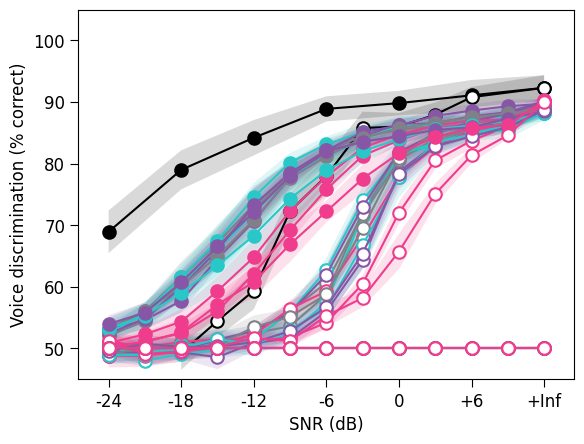

In [39]:
importlib.reload(util_spkr_word_psychophysics_figures)

tag_expt = 'spkr_discrimination_timit_ssn'
list_tag_model = ['human'] + list_regex_dir_model
fig, ax = plt.subplots()
for tag_model in list_tag_model:
    df = EXPERIMENT_DATAFRAMES[tag_expt]
    df = df[df.tag_model == tag_model]
    color, _ = get_color_and_label_from_model_tag(tag_model)
    util_spkr_word_psychophysics_figures.make_plot_voice_discrimination(
        ax,
        df[df.tag_model == tag_model],
        color=color,
        include_legend=False)
plt.show()


In [3]:
importlib.reload(util_localization_psychophysics)
list_regex_dir_model = [
    '/om2/user/msaddler/tfauditoryutil/saved_models/models_localize/v01/grouped/before_pool_factor2/IHC3000Hz_anf384H160M096L/archFrancl??',    
    '/om2/user/msaddler/tfauditoryutil/saved_models/models_localize/v01/IHC3000Hz_anf384H160M096L/archFrancl??',
    '/om2/user/msaddler/tfauditoryutil/saved_models/models_localize/v01/IHC1000Hz_anf384H160M096L/archFrancl??',
    '/om2/user/msaddler/tfauditoryutil/saved_models/models_localize/v01/IHC0320Hz_anf384H160M096L/archFrancl??',
    '/om2/user/msaddler/tfauditoryutil/saved_models/models_localize/v01/IHC0050Hz_anf384H160M096L/archFrancl??',
    
    '/om2/user/msaddler/tfauditoryutil/saved_models/models_localize/v01/grouped/before_pool_factor2/spont0_simplified_IHC3000/archFrancl??',
    '/om2/user/msaddler/tfauditoryutil/saved_models/models_localize/v01/spont0_simplified_IHC3000/archFrancl??',
    '/om2/user/msaddler/tfauditoryutil/saved_models/models_localize/v01/spont0_simplified_IHC1000/archFrancl??',
    '/om2/user/msaddler/tfauditoryutil/saved_models/models_localize/v01/spont0_simplified_IHC0320/archFrancl??',
    '/om2/user/msaddler/tfauditoryutil/saved_models/models_localize/v01/spont0_simplified_IHC0050/archFrancl??',
]

# EXPERIMENT_DATAFRAMES = util_localization_psychophysics.run_localization_experiments(
#     list_regex_dir_model,
#     func_label_to_azim_elev=util_localization_psychophysics.label_to_azim_elev,
#     key_pred_prob='label_loc_int:probs_out',
#     key_pred='label_loc_int:labels_pred',
#     key_true='label_loc_int:labels_true',
#     n_loc_classes=504,
#     workers=60,
#     tag_ckpt='',
#     # list_expt=['speech_in_noise_in_reverb'],
# )

fn_data = '/om2/user/msaddler/tfauditoryutil/paper_phaselocknet/data/model_data_localization.pkl'

# with open(fn_data, 'wb') as f:
#     pickle.dump(EXPERIMENT_DATAFRAMES, f)
# print(fn_data)

with open(fn_data, 'rb') as f:
    EXPERIMENT_DATAFRAMES = pickle.load(f)


In [4]:
importlib.reload(util_localization_psychophysics)

def rmse(x, y):
    return np.linalg.norm(x - y) / np.sqrt(x.shape[0])

dict_metric_function = {
    'pearsonr': scipy.stats.pearsonr,
    # 'spearmanr': scipy.stats.spearmanr,
    'rmse': rmse,
}

df_results = []
for tag_expt in tqdm.tqdm(EXPERIMENT_DATAFRAMES.keys()):
    df = EXPERIMENT_DATAFRAMES[tag_expt]
    df_results_tmp = util_localization_psychophysics.compare_localization_experiment(
        df,
        tag_expt=tag_expt,
        dict_metric_function=dict_metric_function,
        bootstrap_repeats=1000,
        workers=60)
    if df_results_tmp is not None:
        df_results.append(df_results_tmp)
df_results = pd.concat(df_results)

fn_metrics = '/om2/user/msaddler/tfauditoryutil/paper_phaselocknet/data/human_model_comparison_metrics_localization.pkl'
df_results.to_pickle(fn_metrics)
print(fn_metrics)

dict_agg = {}
for k in dict_metric_function.keys():
    dict_agg[k] = 'mean'
    dict_agg[f'bootstrap_list_{k}'] = list
df_results_mean = df_results.groupby(['tag_model']).agg(dict_agg).reset_index()
for k in df_results_mean.columns:
    if 'bootstrap_list_' in k:
        df_results_mean[k] = df_results_mean[k].map(lambda _: np.array(list(_)).mean(axis=0))
df_results_mean['tag_expt'] = 'AVERAGE'
df_results_mean


 18%|███████████████████████▎                                                                                                        | 2/11 [00:21<01:34, 10.48s/it]/om2/user/msaddler/.conda/envs/tf/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/om2/user/msaddler/.conda/envs/tf/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [01:36<00:00,  8.73s/it]


tag_expt='speech_in_noise_in_reverb'` not recognized --> returning None
/om2/user/msaddler/tfauditoryutil/paper_phaselocknet/data/human_model_comparison_metrics_localization.pkl


,tag_model,pearsonr,bootstrap_list_pearsonr,rmse,bootstrap_list_rmse,tag_expt
0,/om2/user/msaddler/tfauditoryutil/saved_models...,0.654006,"[0.6576280453575666, 0.6422792875717263, 0.632...",15.281452,"[14.68306971269656, 17.18255011385953, 13.9170...",AVERAGE
1,/om2/user/msaddler/tfauditoryutil/saved_models...,0.686015,"[0.6979522348142773, 0.6794353034825831, 0.684...",16.195673,"[16.002107931686545, 16.665193089885218, 15.90...",AVERAGE
2,/om2/user/msaddler/tfauditoryutil/saved_models...,0.862214,"[0.8642460396383657, 0.8611802106558691, 0.859...",12.547403,"[12.15560187144185, 13.342781517174828, 11.816...",AVERAGE
3,/om2/user/msaddler/tfauditoryutil/saved_models...,0.753100,"[0.7530362031249036, 0.7503367364053807, 0.760...",12.670109,"[12.293281638000014, 13.14894931025329, 12.178...",AVERAGE
4,/om2/user/msaddler/tfauditoryutil/saved_models...,0.849786,"[0.8597683070918112, 0.8283677418951993, 0.848...",11.686397,"[11.33285283640704, 12.432231108261723, 11.608...",AVERAGE
5,/om2/user/msaddler/tfauditoryutil/saved_models...,0.834790,"[0.8434959677819907, 0.824626479079072, 0.8244...",12.671546,"[12.824712381948498, 13.523335264885986, 12.29...",AVERAGE
6,/om2/user/msaddler/tfauditoryutil/saved_models...,0.662795,"[0.6687799093034159, 0.6600906460945994, 0.659...",15.500817,"[15.374461524862408, 16.764992902527812, 15.52...",AVERAGE
7,/om2/user/msaddler/tfauditoryutil/saved_models...,0.713687,"[0.7118049024316175, 0.7180748652684437, 0.711...",14.719043,"[15.08109832124064, 15.23582714483668, 15.0750...",AVERAGE
8,/om2/user/msaddler/tfauditoryutil/saved_models...,0.840889,"[0.8801039224400583, 0.7952698533592553, 0.859...",12.202867,"[11.587911188936863, 13.652794974352247, 11.60...",AVERAGE
9,/om2/user/msaddler/tfauditoryutil/saved_models...,0.657904,"[0.6753714994715254, 0.6289752969183119, 0.687...",13.665416,"[13.32474451672881, 14.511282640216677, 14.420...",AVERAGE


/tmp/ipykernel_9501/3425181903.py:125: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels, rotation=90)


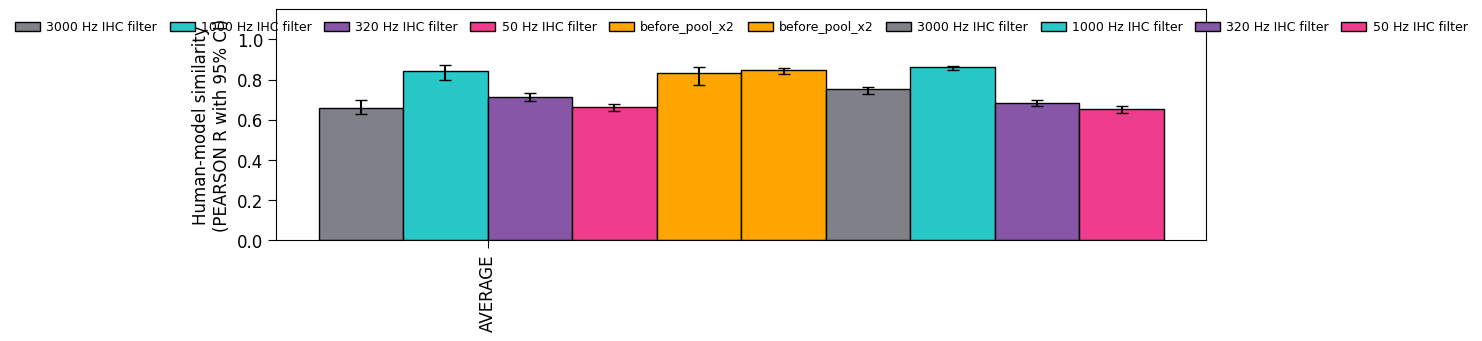

In [5]:
df = pd.concat([df_results, df_results_mean])
list_tag_expt = [
    'AVERAGE',
#     'snr_dependency',
#     'minimum_audible_angle',
#     'itd_ild_weighting',
#     'itd_threshold',
#     'new_ears',
#     'spectral_smoothing',
#     'precedence_effect_localization',
#     'mp_spectral_cues',
#     'bandwidth_dependency',
]
# list_tag_expt = np.unique(df.tag_expt)
list_tag_model = np.unique(df.tag_model)[::-1]
# list_tag_model = [
#     _ for _ in list_tag_model if ('3000' in _) or ('pool' in _)
# ]
fig, ax = make_plot_aggregate_measures(
    df,
    str_ylabel="Human-model similarity\n(PEARSON R with 95% CI)",
    list_tag_expt=list_tag_expt,
    list_tag_model=list_tag_model,
    width=0.05)


In [6]:
import util_pitchnet_psychophysics_figures
importlib.reload(util_pitchnet_psychophysics_figures)

list_regex_dir_model = [
    'human',
    '/om2/user/msaddler/tfauditoryutil/saved_models/PNDv08/IHC3000Hz_anf192H080M048L/arch_0???',
    '/om2/user/msaddler/tfauditoryutil/saved_models/PNDv08/IHC1000Hz_anf192H080M048L/arch_0???',
    '/om2/user/msaddler/tfauditoryutil/saved_models/PNDv08/TRANSPOSED_IHC0320Hz_anf019H008M005L/arch_0???',
    '/om2/user/msaddler/tfauditoryutil/saved_models/PNDv08/TRANSPOSED_IHC0050Hz_anf019H008M005L/arch_0???',
    '/om2/user/msaddler/tfauditoryutil/saved_models/PNDv08/spont0_simplified_IHC3000/arch_0???',
    '/om2/user/msaddler/tfauditoryutil/saved_models/PNDv08/spont0_simplified_IHC1000/arch_0???',
    '/om2/user/msaddler/tfauditoryutil/saved_models/PNDv08/spont0_simplified_IHC0320_TRANSPOSED/arch_0???',
    '/om2/user/msaddler/tfauditoryutil/saved_models/PNDv08/spont0_simplified_IHC0050_TRANSPOSED/arch_0???',
]

experiment_to_func = {
    'bernox2005': util_pitchnet_psychophysics_figures.load_data_bernox2005,
    'mcpherson_snr': util_pitchnet_psychophysics_figures.load_data_mcpherson_snr,
    'transposedtones': util_pitchnet_psychophysics_figures.load_data_transposedtones,
    'pure_tone_spl': util_pitchnet_psychophysics_figures.load_data_pure_tone_spl,
    'freqshiftedcomplexes': util_pitchnet_psychophysics_figures.load_data_freqshiftedcomplexes,
    'mistunedharmonics': util_pitchnet_psychophysics_figures.load_data_mistunedharmonics,
    'altphasecomplexes': lambda _: util_pitchnet_psychophysics_figures.load_data_altphasecomplexes(_, bin_step=0.04),
}

EXPERIMENT_DATAFRAMES = {}
for tag_expt in experiment_to_func.keys():
    print(tag_expt)
    EXPERIMENT_DATAFRAMES[tag_expt] = experiment_to_func[tag_expt](list_regex_dir_model)

fn_data = '/om2/user/msaddler/tfauditoryutil/paper_phaselocknet/data/model_data_pitchnet.pkl'
with open(fn_data, 'wb') as f:
    pickle.dump(EXPERIMENT_DATAFRAMES, f)
with open(fn_data, 'rb') as f:
    EXPERIMENT_DATAFRAMES = pickle.load(f)
print(fn_data)


bernox2005
mcpherson_snr
transposedtones
pure_tone_spl
freqshiftedcomplexes


/rdma/vast-rdma/vast/mcdermott/msaddler/tfauditoryutil/util_pitchnet_psychophysics_figures.py:189: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby(['tag_model', 'fn_eval', 'spectral_envelope_centered_harmonic']).apply(


mistunedharmonics


/rdma/vast-rdma/vast/mcdermott/msaddler/tfauditoryutil/util_pitchnet_psychophysics_figures.py:247: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby(['tag_model', 'fn_eval', 'f0_ref', 'mistuned_harm']).apply(


altphasecomplexes
/om2/user/msaddler/tfauditoryutil/paper_phaselocknet/data/model_data_pitchnet.pkl


In [7]:
importlib.reload(util_pitchnet_psychophysics_figures)

def rmse(x, y):
    return np.linalg.norm(x - y) / np.sqrt(x.shape[0])

dict_metric_function = {
    'pearsonr': scipy.stats.pearsonr,
    # 'spearmanr': scipy.stats.spearmanr,
    'rmse': rmse,
}

df_results = []
for tag_expt in tqdm.tqdm(EXPERIMENT_DATAFRAMES.keys()):
    df = EXPERIMENT_DATAFRAMES[tag_expt]
    df_results_tmp = util_pitchnet_psychophysics_figures.compare_pitchnet_experiment(
        df,
        tag_expt=tag_expt,
        dict_metric_function=dict_metric_function,
        workers=40)
    df_results.append(df_results_tmp)
df_results = pd.concat(df_results)

fn_metrics = '/om2/user/msaddler/tfauditoryutil/paper_phaselocknet/data/human_model_comparison_metrics_pitchnet.pkl'
df_results.to_pickle(fn_metrics)
print(fn_metrics)

dict_agg = {}
for k in dict_metric_function.keys():
    dict_agg[k] = 'mean'
    dict_agg[f'bootstrap_list_{k}'] = list
df_results_mean = df_results.groupby(['tag_model']).agg(dict_agg).reset_index()
for k in df_results_mean.columns:
    if 'bootstrap_list_' in k:
        df_results_mean[k] = df_results_mean[k].map(lambda _: np.array(list(_)).mean(axis=0))
df_results_mean['tag_expt'] = 'AVERAGE'
df_results_mean


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:40<00:00,  5.79s/it]


/om2/user/msaddler/tfauditoryutil/paper_phaselocknet/data/human_model_comparison_metrics_pitchnet.pkl


,tag_model,pearsonr,bootstrap_list_pearsonr,rmse,bootstrap_list_rmse,tag_expt
0,/om2/user/msaddler/tfauditoryutil/saved_models...,0.910279,"[0.9068316788563011, 0.9160271635698997, 0.910...",0.524216,"[0.50204241377263, 0.5500496602006492, 0.51323...",AVERAGE
1,/om2/user/msaddler/tfauditoryutil/saved_models...,0.925707,"[0.9170135230489327, 0.9247745779833118, 0.920...",0.482905,"[0.473552925139055, 0.5250239381813554, 0.4883...",AVERAGE
2,/om2/user/msaddler/tfauditoryutil/saved_models...,0.793539,"[0.7876096034343115, 0.7788447829299912, 0.782...",1.222961,"[1.226856980528014, 1.300730428722725, 1.22699...",AVERAGE
3,/om2/user/msaddler/tfauditoryutil/saved_models...,0.802980,"[0.8061508847149893, 0.7988517312579038, 0.801...",1.238582,"[1.2658300913920808, 1.208999720792326, 1.2862...",AVERAGE
4,/om2/user/msaddler/tfauditoryutil/saved_models...,0.829544,"[0.826978319161178, 0.827655112761347, 0.82499...",1.160911,"[1.174854749317187, 1.1911408502070988, 1.1511...",AVERAGE
5,/om2/user/msaddler/tfauditoryutil/saved_models...,0.858766,"[0.8550570794168096, 0.8402953189859055, 0.862...",1.078107,"[1.1105683270958175, 1.1869185869819001, 1.033...",AVERAGE
6,/om2/user/msaddler/tfauditoryutil/saved_models...,0.915869,"[0.9134767033982651, 0.9129509471744143, 0.910...",0.582576,"[0.5674737376742668, 0.6188198504075855, 0.580...",AVERAGE
7,/om2/user/msaddler/tfauditoryutil/saved_models...,0.927636,"[0.9162299923828237, 0.9290604855005203, 0.924...",0.601502,"[0.582634134194968, 0.6252283831968074, 0.5877...",AVERAGE


/om2/user/msaddler/tfauditoryutil/saved_models/PNDv08/spont0_simplified_IHC3000/arch_0???
/om2/user/msaddler/tfauditoryutil/saved_models/PNDv08/spont0_simplified_IHC1000/arch_0???
/om2/user/msaddler/tfauditoryutil/saved_models/PNDv08/spont0_simplified_IHC0320_TRANSPOSED/arch_0???
/om2/user/msaddler/tfauditoryutil/saved_models/PNDv08/spont0_simplified_IHC0050_TRANSPOSED/arch_0???
/om2/user/msaddler/tfauditoryutil/saved_models/PNDv08/TRANSPOSED_IHC0320Hz_anf019H008M005L/arch_0???
/om2/user/msaddler/tfauditoryutil/saved_models/PNDv08/TRANSPOSED_IHC0050Hz_anf019H008M005L/arch_0???
/om2/user/msaddler/tfauditoryutil/saved_models/PNDv08/IHC3000Hz_anf192H080M048L/arch_0???
/om2/user/msaddler/tfauditoryutil/saved_models/PNDv08/IHC1000Hz_anf192H080M048L/arch_0???


/tmp/ipykernel_9501/3425181903.py:125: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels, rotation=90)


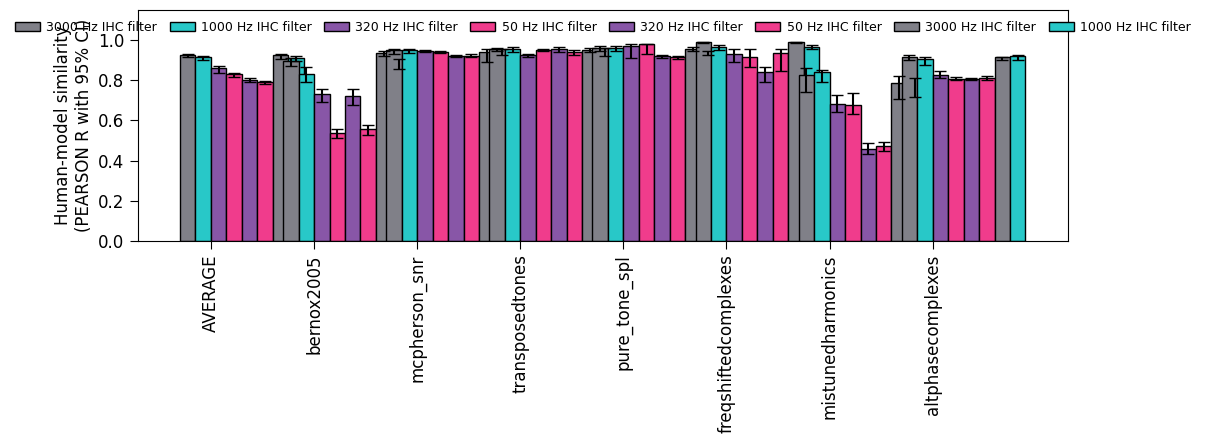

In [8]:
df = pd.concat([df_results, df_results_mean])
list_tag_expt = ['AVERAGE'] + list(EXPERIMENT_DATAFRAMES.keys())
list_tag_model = np.unique(df['tag_model'].values)[::-1]
# list_tag_model = [list_tag_model[_] for _ in [2,3,0,1]]

for tag_model in list_tag_model:
    print(tag_model)

fig, ax = make_plot_aggregate_measures(
    df,
    str_ylabel="Human-model similarity\n(PEARSON R with 95% CI)",
    width=0.15,
#     key_metric='mae',
#     str_ylabel=None,
#     ylimits=None,
#     yticks=None,
    list_tag_expt=list_tag_expt,
    list_tag_model=list_tag_model)
